## import packages, define variables

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import pandas as pd # for creation of data frames
import numpy as np #
import seaborn as sns
import nibabel as nib # for loading niftis etc. as arrays
import matplotlib.pyplot as plt # for plotting data
#the output of plotting commands is displayed inline, directly below the code cell that produced it
%matplotlib inline 
import os,glob
from nilearn import plotting, input_data, image #for plotting & working with niftis

import pathlib
import pyxnat

###################### update path!! #####################################
base_path = '/home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/' ####
##########################################################################

#import qBOLD functions
#import sys
#sys.path.append(os.path.join(base_path + 'scripts/'))
#import mqBOLD_functions as qB


### define FSL directories ######################################################
os.environ["FSLDIR"]='/usr/share/fsl/5.0'
os.environ["FSLOUTPUTTYPE"]='NIFTI_GZ'
os.environ["FSLTCLSH"]='/usr/bin/tclsh'
os.environ["FSLWISH"]='/usr/bin/wish'
os.environ["FSLMULTIFILEQUIT"]="True"
os.environ["LD_LIBRARY_PATH"]='/usr/share/fsl/5.0:/usr/lib/fsl/5.0'
#################################################################################

In [3]:
data_dir = base_path + 'data/'
derivatives_dir = data_dir + 'derivatives'
raw_dir = data_dir + 'rawdata'
results_dir = base_path + 'results'

sns.set_style("whitegrid")

## N=40
sids = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55, 58, 59, 60, 61, 63, 64, 65, 66, 67, 68]
## N=30
sids_30 = [19, 20, 21, 23, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 43, 44, 46, 47, 48, 49, 50, 51, 52, 54, 55]
## N=10
sids_10 = [58, 59, 60, 61, 63, 64, 65, 66, 67, 68]

df_participants = pd.read_csv(data_dir + '/participants.tsv',sep='\t')

## Calculate CMRO2 per subject and condition

In [60]:
for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)

    #download & binarize brain mask, store in 'masker' object
    BrMask_CSF = os.path.join(derivatives_dir, sub, 'anat',  sub + '_BrMsk_CSF.nii')
    mask = image.math_img('img> 0.1', img = BrMask_CSF)
    masker = input_data.NiftiMasker(mask_img=mask)
    
    # download O2 sat & hematocrit values from xnat
    Hk = df_participants.query('participant_id==@sub')['Hct'].values
    O2sat = df_participants.query('participant_id==@sub')['O2sat'].values
        
    if ID < 56: ## here, all 4 conditions were acquired        
        conds = ['rest', 'control', 'mem', 'calc']
        
    if ID > 55:        
        conds = ['control', 'calc'] 
        
    for k, cond in enumerate(conds): 

        #  CBF and OEF niftis f
        CBF = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-' + cond + '_space-T2_cbf.nii')
        CBF_np = masker.fit_transform(CBF)
        OEF = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-' + cond + '_space-T2_oef.nii')
        OEF_np = masker.fit_transform(OEF)
        
        # upscale CBF by 25% because 4 background suppression pulses
        CBF_upscaled = CBF_np / 0.75

        #calculate CaO2 value per subject, O2sat as a fraction
        #
        CaO2 = 0.334 * float(Hk) * 55.6 * float(O2sat)/100;
        
        ## calculate CMRO2 parameter map
        CMRO2 = CBF_upscaled * OEF_np * CaO2 /100;
        
        #store CMRO2 parameter map as nifti
        CMRO2_vol = masker.inverse_transform(CMRO2)
        ## here, CBV was only acquired in control
        if ID < 56:
            CMRO2_vol.to_filename(os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-' + cond + '_space-T2_desc-orig_cmro2.nii'))
        ## here, CBV correction was applied: CBV was also acquired in calc
        if ID > 55 and cond == 'calc':
            CMRO2_vol.to_filename(os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-' + cond + '_space-T2_desc-CBV_cmro2.nii'))        
        if ID > 55 and cond == 'control':
            CMRO2_vol.to_filename(os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-' + cond + '_space-T2_desc-orig_cmro2.nii')) 
            
        ## plot image
        #plotting.plot_img(CMRO2_vol, cmap='jet', colorbar=True, vmin=10, vmax=300, title=sub + ': ' + cond)

sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068


## CBV calc-correction

In [61]:
### create 'new' CBV calc images ###

df_Glasser = pd.read_csv(derivatives_dir + '/CBV_correction_factor.tsv',sep='\t')
correction_factor_percchange = df_Glasser['CBV_percchange']

for i,ID in enumerate(sids_30):
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)

    ## download CBV control map
    CBV_control = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-control_space-T2_cbv.nii')
    CBV_control_img = nib.load(CBV_control)
    CBV_control_arr = np.array(CBV_control_img.dataobj)
    
    ## download Glasser360 parcellation
    Glasser_T2space = os.path.join(derivatives_dir, 'Glasser360_T2space.nii.gz')
    if ID > 23:
        Glasser_T2space = os.path.join(derivatives_dir, 'Glasser360_T2space_35vol.nii.gz')
    Glasser_img=nib.load(Glasser_T2space)
    Glasser_arr=np.array(Glasser_img.dataobj)
       
    ## CBV control img is the baseline, replace voxels that are in Glasser parcels with adjusted CBV values
    CBV_calc_corrected = CBV_control_arr 
    for r, region in enumerate(range(1, 361)): 
        correction_factor = correction_factor_percchange/100 ##from percent to ratio
        CBV_calc_corrected[Glasser_arr==region] = CBV_control_arr[Glasser_arr==region] + (correction_factor[r]*CBV_control_arr[Glasser_arr==region])
    

    ## turn into nifti, display
    CBV_calc_corrected_img = nib.Nifti1Image(CBV_calc_corrected, CBV_control_img.affine)
    T1w_T2 = os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii')

    #plotting.plot_img(CBV_calc_corrected_img,bg_img=T1w_T2, cmap='jet', colorbar=True, threshold=0.1, vmax=10, black_bg=True, 
    #                             title = 'CBV calc corrected for sub ' + subj_id)
    #plotting.plot_img(CBV_calc_corrected_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=10, threshold=0.1,
    #               title = 'CBV calc corrected for sub ' + subj_id)
    #plotting.plot_img(CBV_control_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=10, threshold=0.1,
    #               title = 'CBV control for sub ' + subj_id)
    
    ## save 
    nib.save(CBV_calc_corrected_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_cbv.nii'))


sub-p019
sub-p020
sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055


sub-p055

Final result: 
0.999878 -0.009904 0.012096 0.603269 
0.010270 0.999480 -0.030571 -1.741893 
-0.011787 0.030692 0.999459 -5.149668 
0.000000 0.000000 0.000000 1.000000 



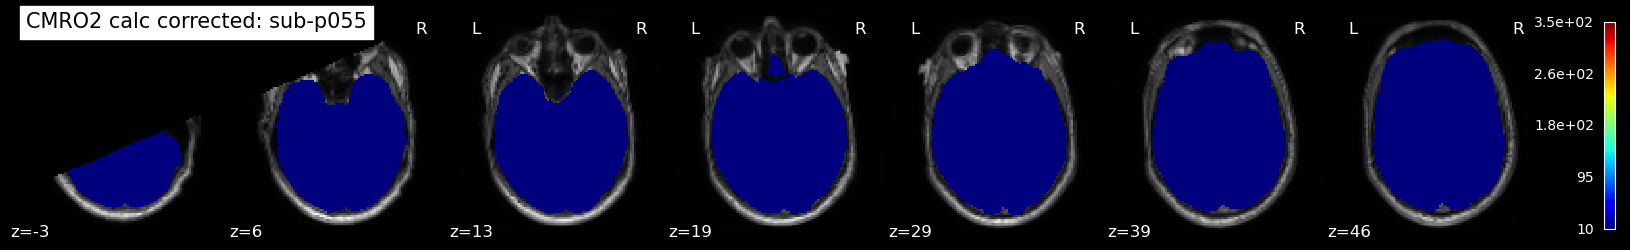

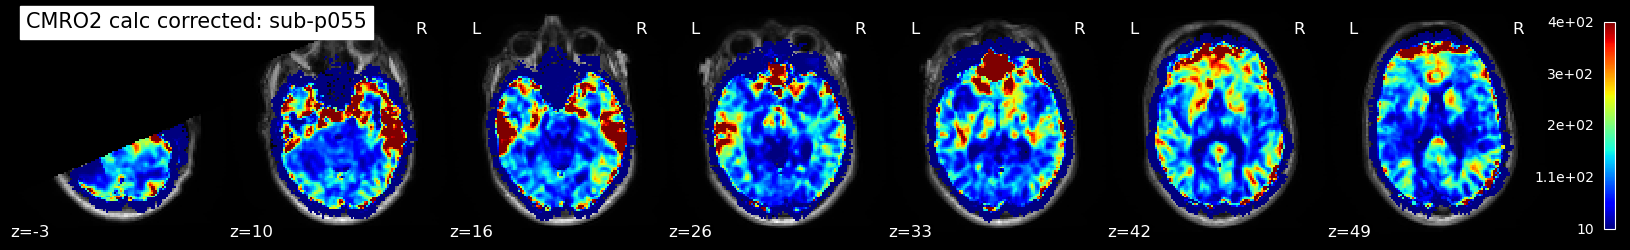

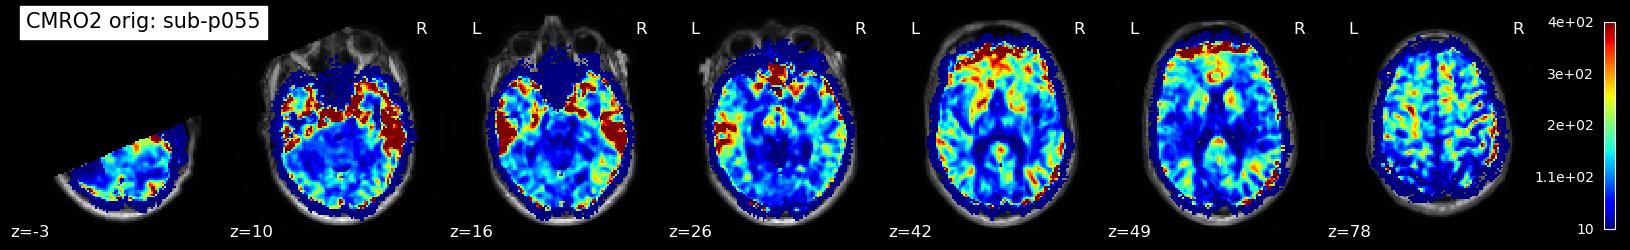

In [74]:
### recalculate OEF and CMRO2 for calc ###

for i,ID in enumerate(sids_30):
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)
    
    # download O2 sat & hematocrit values from xnat
    Hct = df_participants.query('participant_id==@sub')['Hct'].values
    O2sat = df_participants.query('participant_id==@sub')['O2sat'].values
        
    ##############################
    ## calculate adjusted rOEF ##
    #############################
    
    
    R2prime_calc =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_R2prime.nii')
    R2prime_calc_nii = nib.load(R2prime_calc)
    R2prime_calc_arr = np.array(R2prime_calc_nii.dataobj)
    
    ## co-register CBV and T2, do not have the same number of slices for ID<26! 
    CBV_calc_corrected =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_cbv.nii')
    CBV_calc_corrected_nii = nib.load(CBV_calc_corrected)
    CBV_calc_corrected_arr = np.array(CBV_calc_corrected_nii.dataobj)
    
    BrMask_CSF = os.path.join(derivatives_dir, sub, 'anat',  sub + '_BrMsk_CSF.nii')
    BrMsk_CSF_nii = nib.load(BrMsk_CSF)
    BrMsk_CSF_arr = np.array(BrMsk_CSF_nii.dataobj)
      
    ## here, the brain mask has too many slices
    T1w_T2 = os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii')
    T1w_T2_brain = os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_desc-brain_T1w.nii.gz')
    ! bet {T1w_T2} {T1w_T2_brain}
    BrMask_CSF_sliced = os.path.join(derivatives_dir, sub, 'anat',  sub + '_BrMsk_CSF_resliced.nii.gz')
    ! flirt -in {BrMask_CSF} -ref {T1w_T2_brain} -out {BrMask_CSF_sliced} -dof 6 
    plotting.plot_img(BrMask_CSF_sliced, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=350, vmin = 10, threshold=0.1,
                   title = 'CMRO2 calc corrected: ' + sub)
    
    BrMsk_CSF_nii = nib.load(BrMask_CSF_sliced)
    BrMsk_CSF_arr = np.array(BrMsk_CSF_nii.dataobj)

        
    mask = BrMsk_CSF_arr>0.5;
    
    # [Hz], physiologic constant derived from literature
    # 0.85: factor for small-vessel hematocrit
    C = 4/3*267.61918*np.pi*0.264*(Hct/100)*0.85*3; # 317 Hz

    rCBV = CBV_calc_corrected_arr/100.0; #CBV fraction, e.g. CBV_WM = 0.015
    rCBV[rCBV < 0] = 0;
    eps=2.2204e-16 #to not divide by zero
    rOEF = (R2prime_calc_arr / (C*rCBV+eps)) * mask

    # reasonable boundary to avoid unreasonably high hot spots
    rOEFmax_DSC = 5*np.nanmedian(rOEF[mask]);
    if rOEFmax_DSC < 1.5:
            rOEFmax_DSC = 1.5 # FIXED Threshold
    rOEF[rOEF > rOEFmax_DSC] = rOEFmax_DSC
    rOEF = rOEF *mask

    rOEF_calc_corrected_img = nib.Nifti1Image(rOEF, CBV_calc_corrected_nii.affine)
    nib.save(rOEF_calc_corrected_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_desc-CBV_oef.nii'))


    ##############################
    ## calculate adjusted CMRO2 ##
    ##############################
    
    
    # download CSF and OEF niftis from xnat
    CBF = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_cbf.nii')
    CBF_nii = nib.load(CBF)
    CBF_np= np.array(CBF_nii.dataobj)
    OEF_corrected = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_desc-CBV_oef.nii')
    OEF_nii = nib.load(OEF_corrected)
    OEF_np= np.array(OEF_nii.dataobj)
    
    # upscale CSF by 25% because of scanner
    CBF_upscaled = CBF_np / 0.75 # upscale CSF by 25% because of scanner

    #calculate CaO2 value per subject, O2sat as a fraction
    CaO2 = 0.334 * Hct * 55.6 * float(O2sat)/100;
        
    ## calculate CMRO2 parameter map
    CMRO2 = CBF_upscaled * OEF_np * CaO2 /100;
    CMRO2 = CMRO2 * mask
        
    #store CMRO2 parameter map as nifti
    CMRO2_calc_corrected_img = nib.Nifti1Image(CMRO2, CBV_calc_corrected_nii.affine)

    nib.save(CMRO2_calc_corrected_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_desc-CBV_cmro2.nii.gz'))

    ## plot output
    T1w_T2 = os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii')
    plotting.plot_img(CMRO2_calc_corrected_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=400, vmin = 10, threshold=0.1,
                   title = 'CMRO2 calc corrected: ' + sub)
    CMRO2_calc_img = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_desc-orig_cmro2.nii')
    plotting.plot_img(CMRO2_calc_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=400, vmin = 10, threshold=0.1,
                   title = 'CMRO2 orig: ' + sub)

### store BOLD percchange niftis

In [75]:
for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)
    
    if ID < 56:             
        contrasts = ['calccontrol', 'memcontrol', 'calcrest']
                    
        func_T2space = os.path.join(derivatives_dir, sub, 'func',  sub +  '_task-all_space-T2_filtered_func.nii.gz')
        func_img = nib.load(func_T2space)
        func_arr = np.array(func_img.dataobj) 

        ##taking HRF into account, i.e. only take time-points after 5TR = 7sec
        rest = func_arr[:, :, :,list(range(5, 25)) + list(range(130, 150)) + list(range(230, 250)) + list(range(330, 350))] #rest
        baseline_rest = np.nanmedian(rest, axis=3) #median across time-points

        control = func_arr[:, :, :, list(range(80, 100)) + list(range(205, 225)) + list(range(280, 300)) + list(range(355, 375))]
        baseline_control = np.nanmedian(control, axis=3) #median across time-points

                
        ## get %change per time-point
        percchange_control=np.zeros((func_arr.shape))
        percchange_rest=np.zeros((func_arr.shape))
        percchange_mem = np.zeros((func_arr.shape))
        for i in range(0, func_arr.shape[3]):
            percchange_control[:, :, :, i] = 100*(func_arr[:, :, :, i] - baseline_control) / baseline_control
            percchange_rest[:, :, :, i] = 100*(func_arr[:, :, :, i] - baseline_rest) / baseline_rest

        for l, con in enumerate(contrasts): 

            if con == 'calccontrol':
                percchange = np.nanmedian(percchange_control[:, :, :,list(range(55, 75)) + list(range(155, 175)) + list(range(255, 275)) + list(range(305, 325))], axis=3)

            if con == 'memcontrol':
                percchange = np.nanmedian(percchange_control[:, :, :,list(range(30, 50)) + list(range(105, 125)) + list(range(180, 200)) + list(range(380, 400))], axis=3)

            if con == 'calcrest':
                percchange = np.nanmedian(percchange_rest[:, :, :,list(range(55, 75)) + list(range(155, 175)) + list(range(255, 275)) + list(range(305, 325))], axis=3)

            ## save nifti
            T1w_T2 = nib.load(os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii'))
            percchange_img = nib.Nifti1Image(percchange, T1w_T2.affine)
            nib.save(percchange_img, os.path.join(derivatives_dir, sub, 'func',  sub +  '_task-'+con+'_space-T2_BOLD_percchange.nii.gz'))


    if ID > 55:
        con = 'calccontrol'
        
        func_T2space = os.path.join(derivatives_dir, sub, 'func',  sub +  '_task-all_space-T2_filtered_func.nii.gz')
        func_img = nib.load(func_T2space)
        func_arr = np.array(func_img.dataobj)             

        ##taking HRF into account, i.e. only take time-points after 5TR = 7sec
        control = func_arr[:, :, :, list(range(5, 25)) + list(range(55, 75)) + list(range(105, 125)) + list(range(155, 175))]
        baseline_control = np.nanmedian(control, axis=3) #median across time-points

        ## get %change per time-point
        percchange_control=np.zeros((func_arr.shape))
        for i in range(0, func_arr.shape[3]):
            percchange_control[:, :, :, i] = 100*(func_arr[:, :, :, i] - baseline_control) / baseline_control

        percchange = np.nanmedian(percchange_control[:, :, :,list(range(30, 50)) + list(range(80, 100)) + list(range(130, 150)) + list(range(180, 200))], axis=3)

        ## save nifti
        T1w_T2 = nib.load(os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii'))
        percchange_img = nib.Nifti1Image(percchange, T1w_T2.affine)
        nib.save(percchange_img, os.path.join(derivatives_dir, sub, 'func',  sub +  '_task-'+con+'_space-T2_BOLD_percchange.nii.gz'))


sub-p021
sub-p023
sub-p026
sub-p027
sub-p028
sub-p029
sub-p030
sub-p031
sub-p032
sub-p033
sub-p034
sub-p035
sub-p036
sub-p037
sub-p038
sub-p039
sub-p040
sub-p043
sub-p044
sub-p046
sub-p047
sub-p048
sub-p049
sub-p050
sub-p051
sub-p052
sub-p054
sub-p055
sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068


### semi-quantitative CMRO2

In [76]:
import sys 
#!{sys.prefix}/bin/pip install -q nbformat 
import nbformat 

In [77]:
## run qBOLD toolbox
%run qBOLD_fun.ipynb

sub-p058
sub-p059
sub-p060
sub-p061
sub-p063
sub-p064
sub-p065
sub-p066
sub-p067
sub-p068


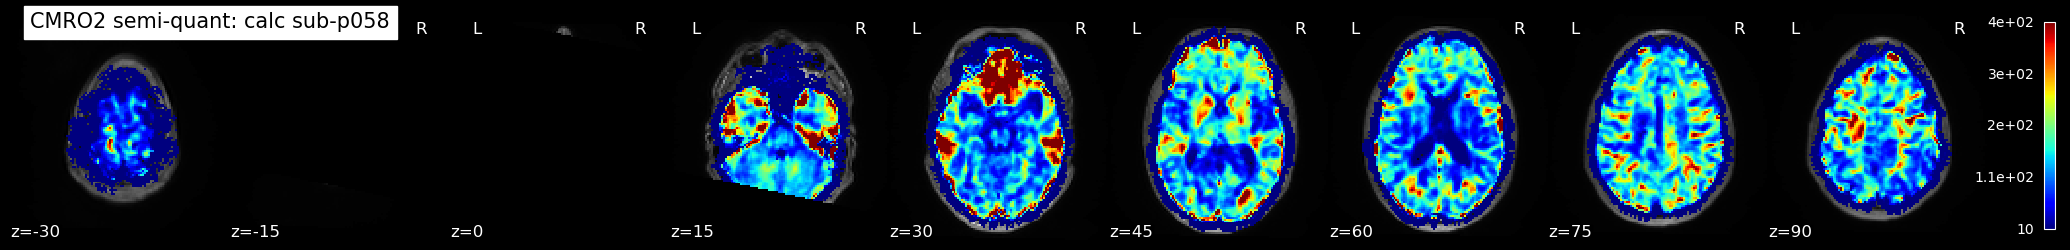

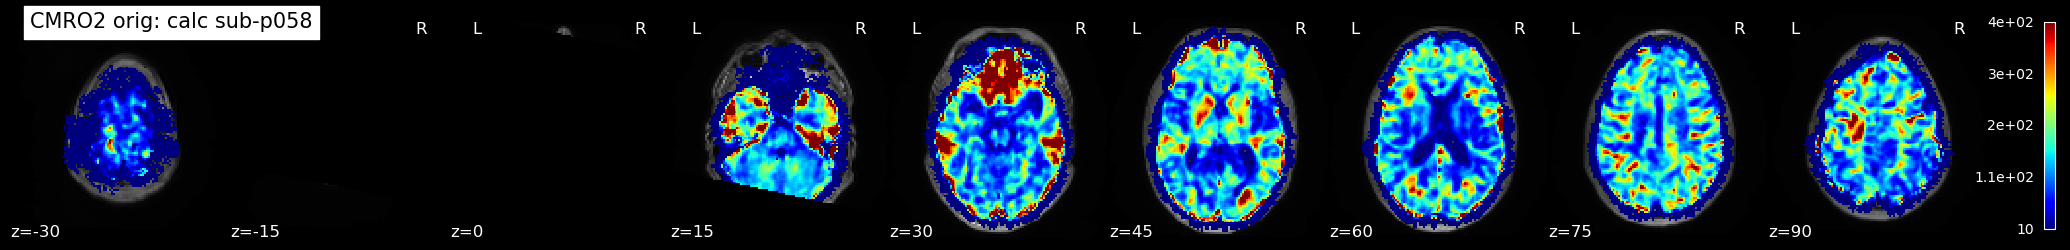

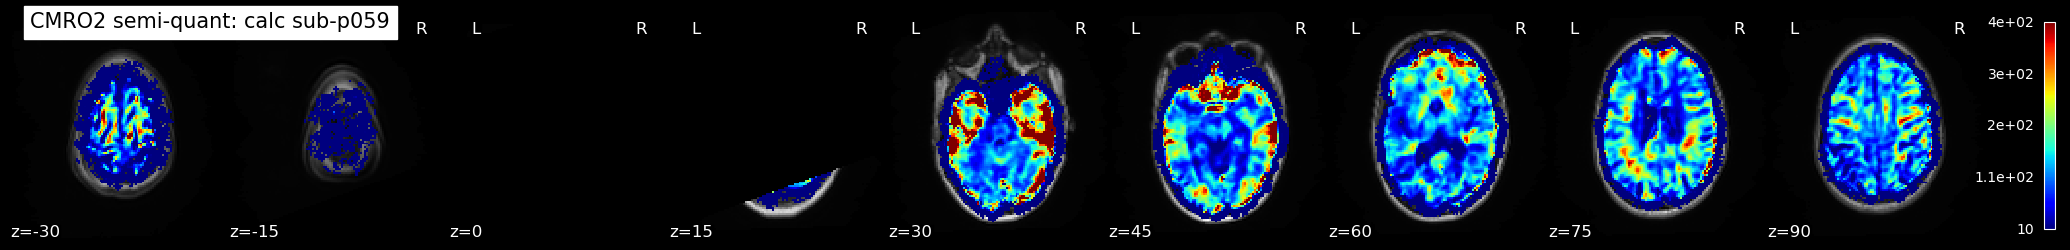

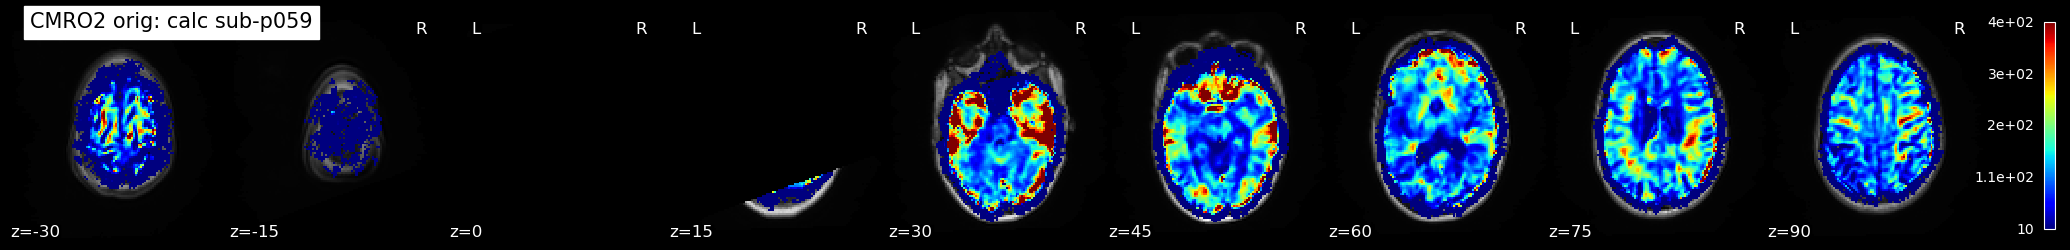

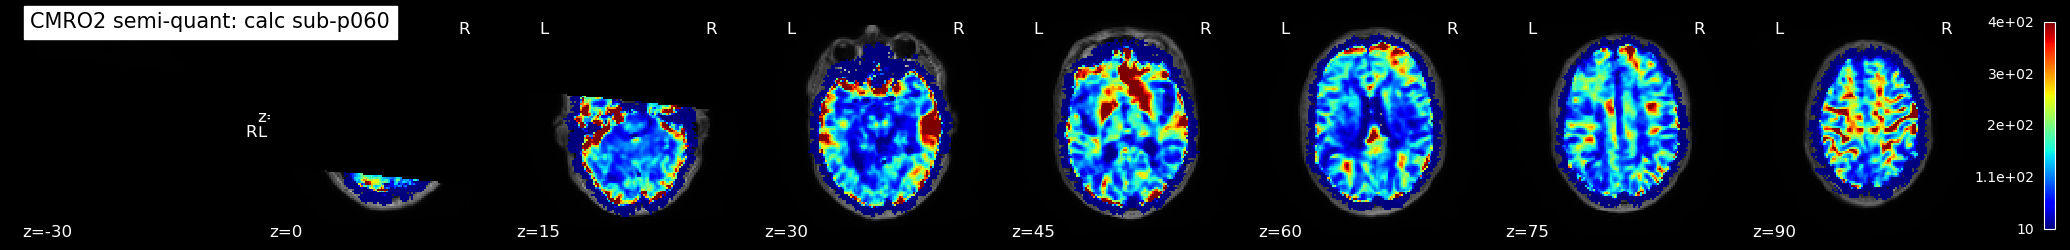

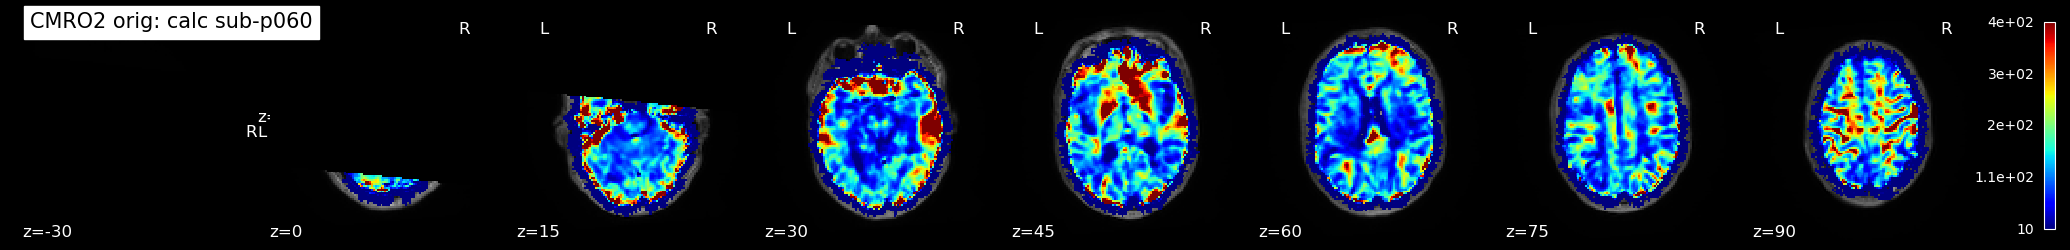

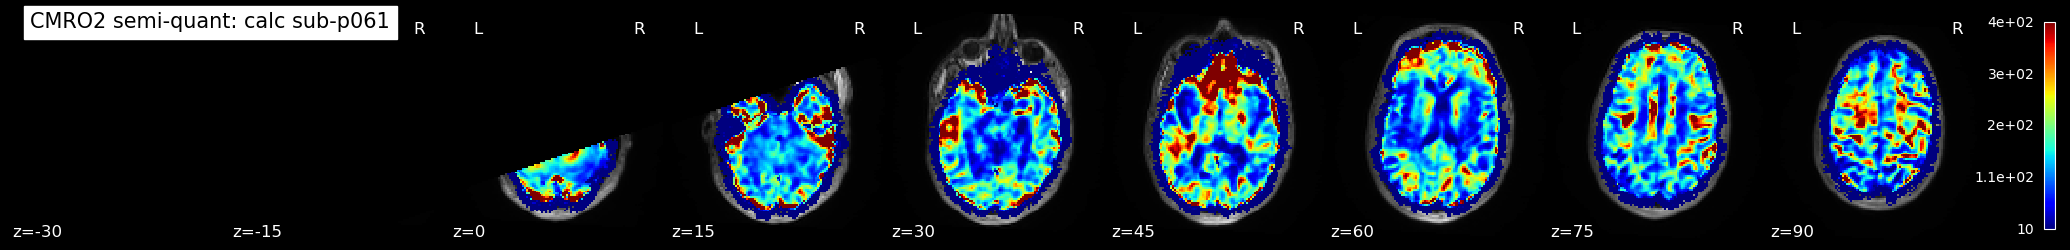

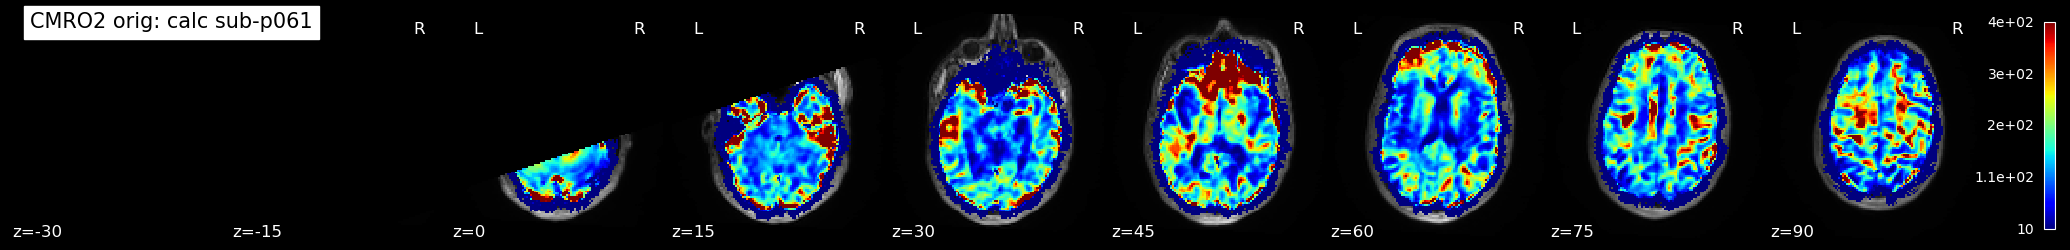

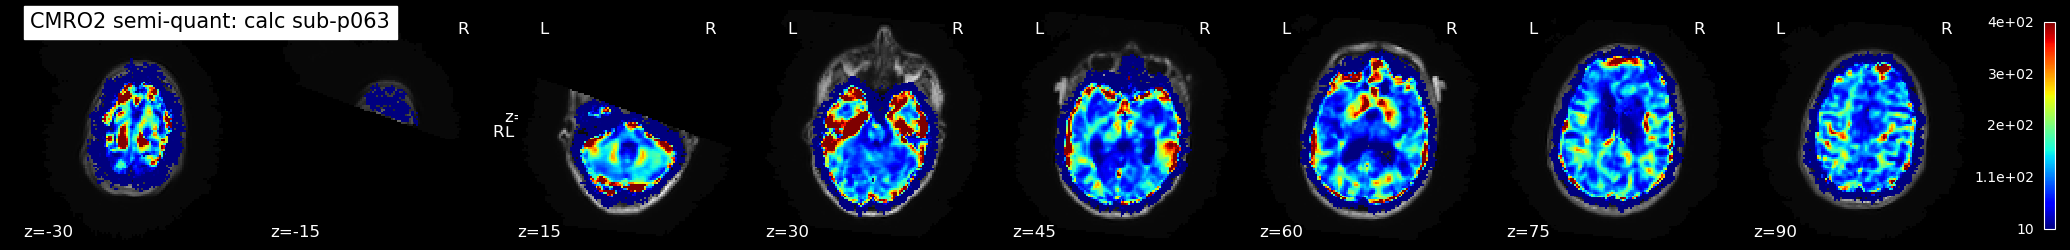

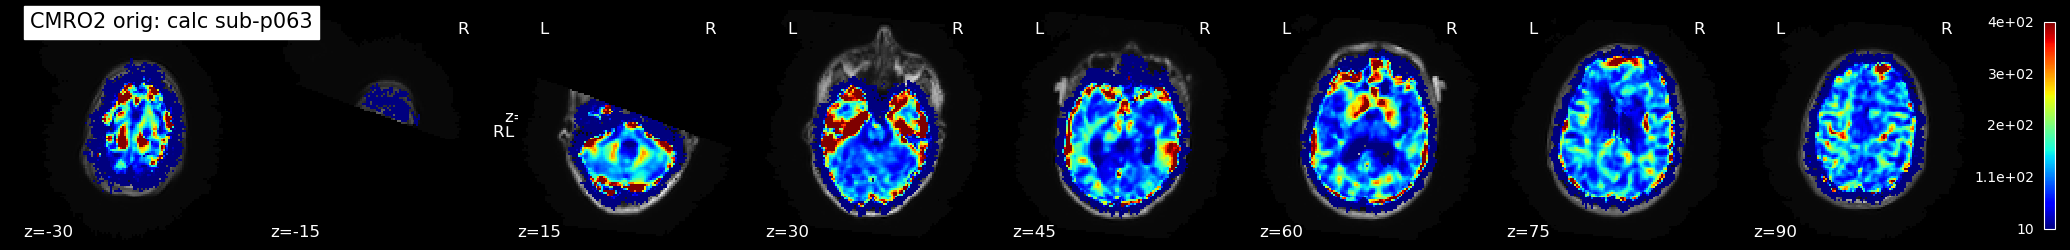

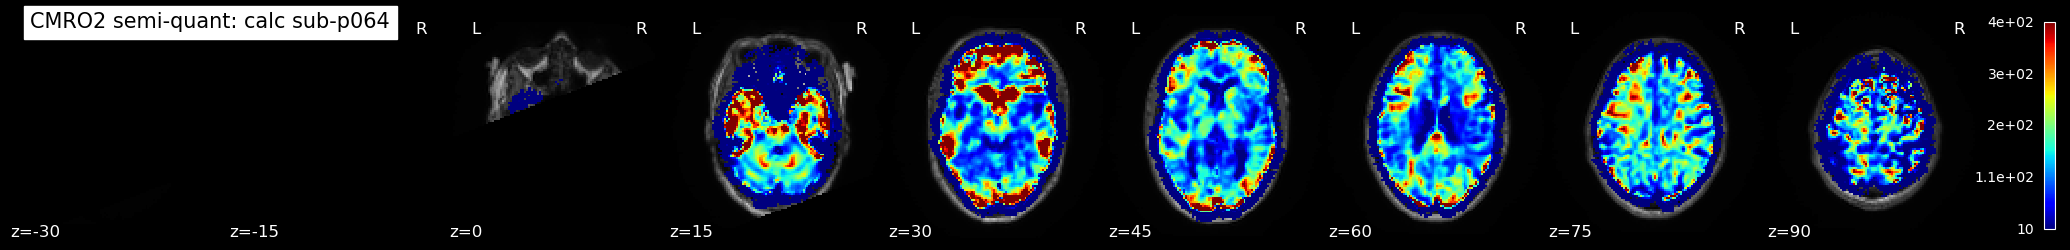

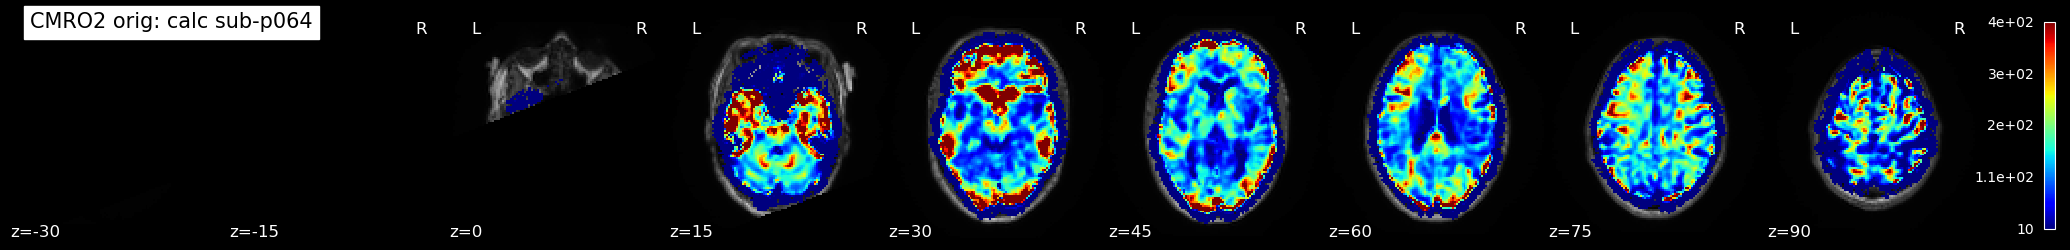

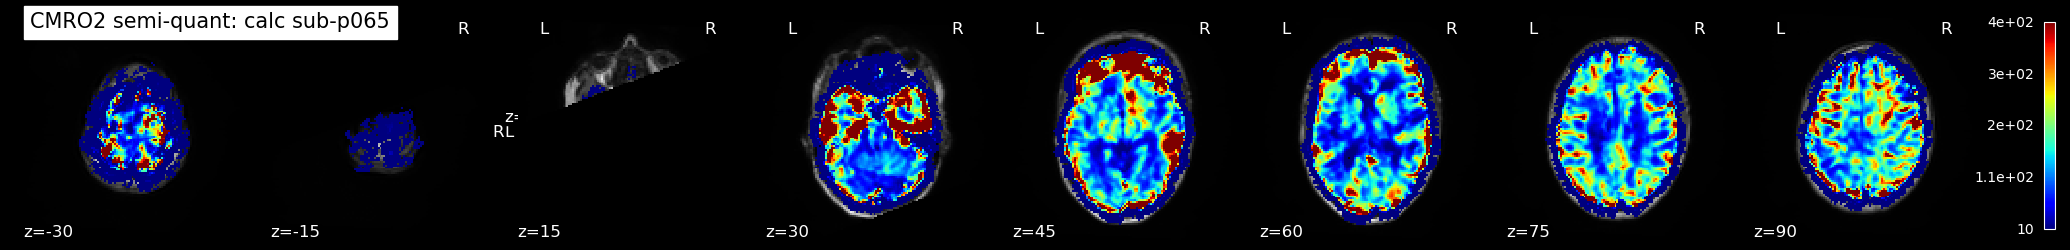

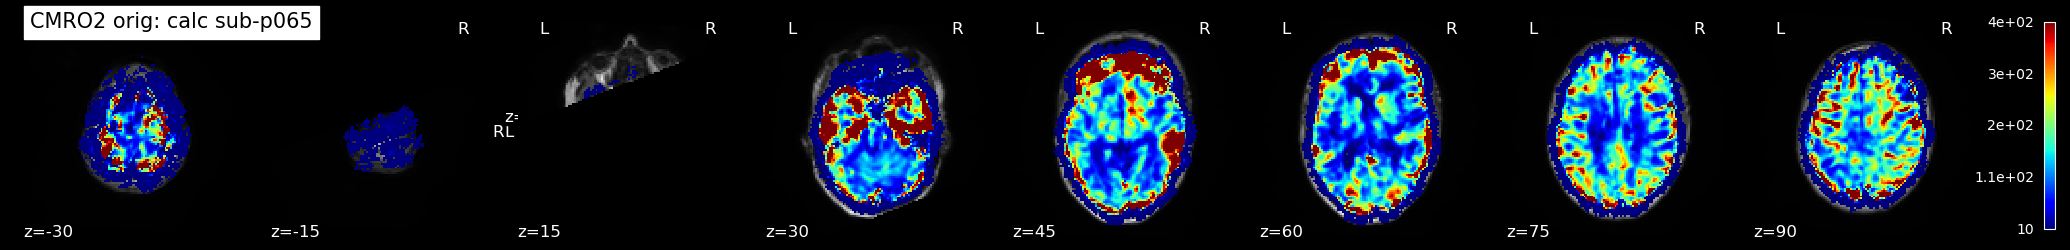

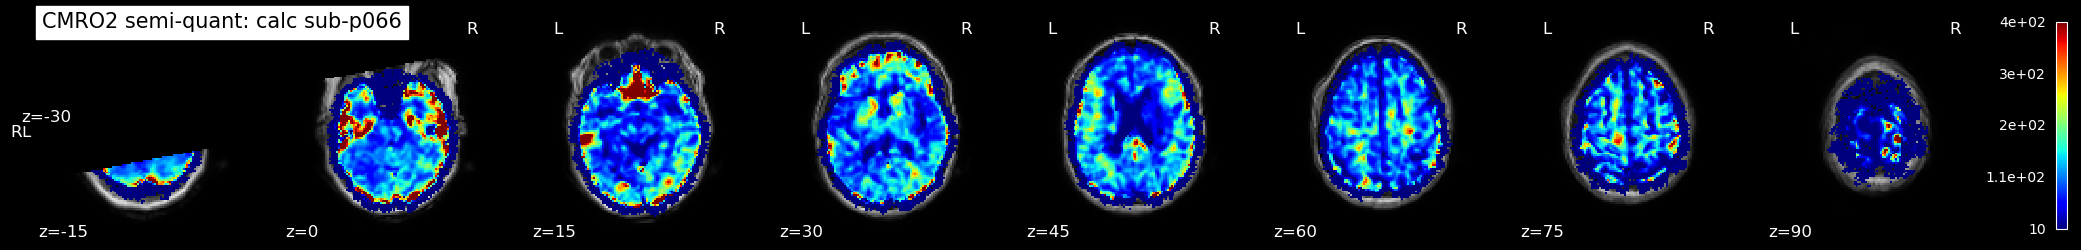

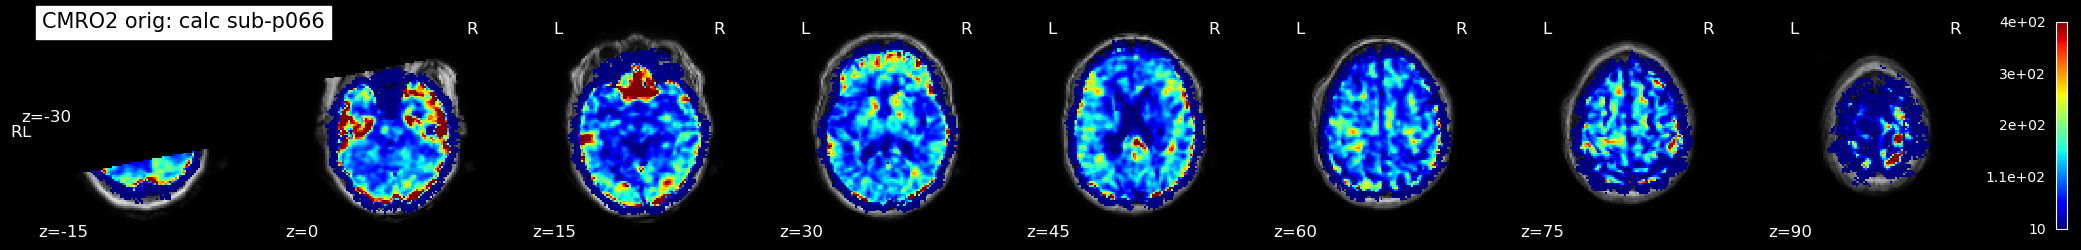

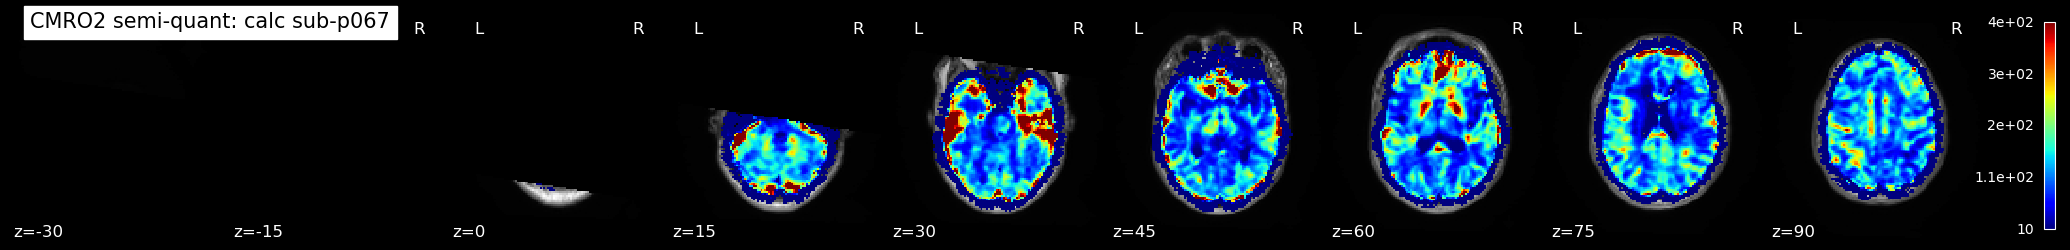

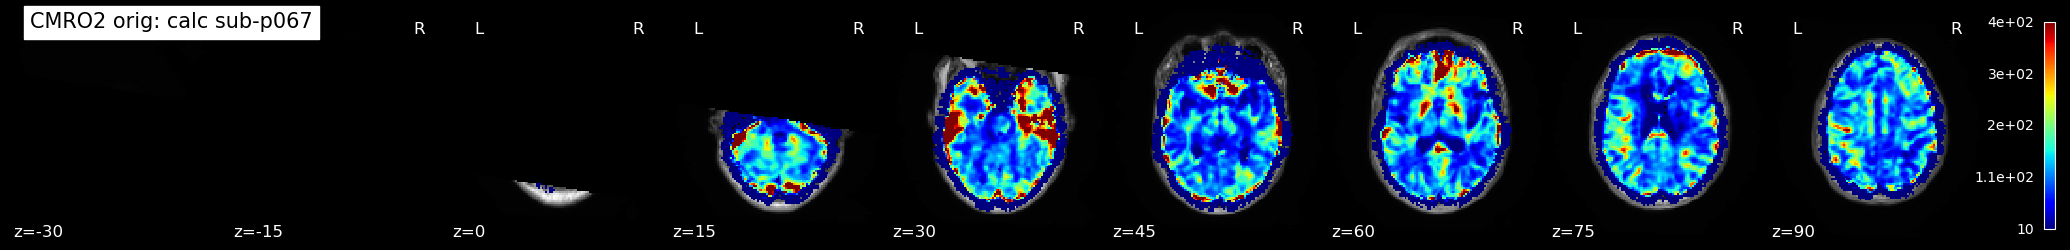

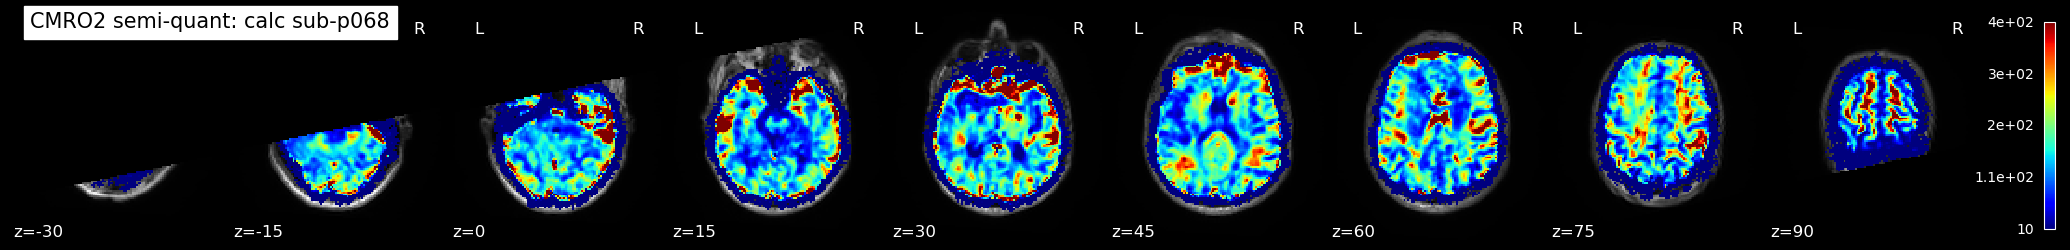

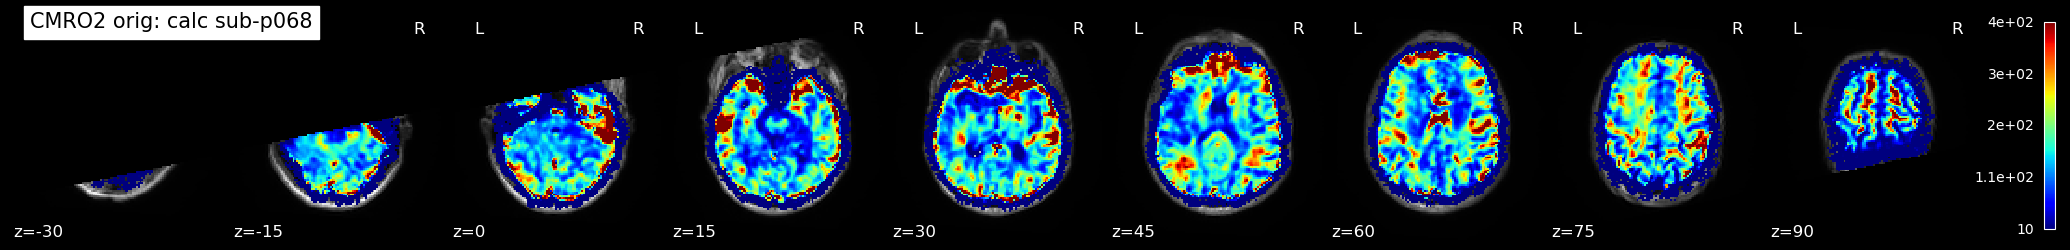

In [80]:
## which contrast/baseline do we want to look at?
#baseline='rest'
baseline='control'
#conds=['calc']

### calculate based on CBV-corrected calc or without CBV-correction?
mode = 'corrected'
#mode = 'noCBV'

coords=(-30, -15, 0, 15, 30, 45, 60, 75, 90)
sids = [58, 59, 60, 61, 63, 64, 65, 66, 67, 68]

TE=30

for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)
    
    # download O2 sat & hematocrit values from xnat
    Hct = df_participants.query('participant_id==@sub')['Hct'].values
    O2sat = df_participants.query('participant_id==@sub')['O2sat'].values
    
    ## load R2` and %BOLD change
    R2s_baseline =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+baseline+'_space-T2_R2prime.nii')
    R2s_baseline_nii = nib.load(R2s_baseline)
    R2s_baseline_arr = np.array(R2s_baseline_nii.dataobj)
   # plotting.plot_img(R2s_baseline, cmap='jet', cut_coords=coords, display_mode='z',colorbar = True, vmin = -20, vmax=20, title=subj_id + ' R2s baseline')
    
    if ID < 56:
        conds=['mem', 'calc']
    if ID > 55:
        conds=['calc']
        
    for cond in conds:
        con = cond + baseline
        BOLD = os.path.join(derivatives_dir, sub, 'func',  sub +  '_task-'+con+'_space-T2_BOLD_percchange.nii.gz')

        #plotting.plot_img(BOLD, cmap='jet', cut_coords=coords, display_mode='z',colorbar = True, vmin = -2, vmax=2, title=subj_id + ' BOLD percchange')
        BOLD_nii = nib.load(BOLD)
        BOLD_arr = np.array(BOLD_nii.dataobj)

        ########################
        ## calculate R2'     ###
        ########################

        ##recalcalute task R2' based on R2' baseline and BOLD change
        R2s_Fujita = FujitaR2ptask_nii(R2s_baseline_arr, BOLD_arr, TE)
        ## turn into nifti and save
        R2s_Fujita_nii = nib.Nifti1Image(R2s_Fujita, R2s_baseline_nii.affine)
        nib.save(R2s_Fujita_nii, os.path.join(derivatives_dir, sub, 'qmri',   sub + '_task-'+cond+'_space-T2_desc-semi-quant_R2prime.nii.gz'))
        #plotting.plot_img(R2s_Fujita_nii, cmap='jet', cut_coords=coords, display_mode='z',colorbar = True, vmin = -20, vmax=20, title=subj_id + ' R2s Fujita')

        ###################
        ## calculate OEF ##
        ###################
        ## download corrected CBV map
        if cond == 'calc': 
            if mode == 'corrected':## for calc, we take the corrected CBV values!
                CBV =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-calc_space-T2_cbv.nii')
            if mode == 'noCBV': ## if not corrected, we take baseline CBV values
                CBV =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-control_space-T2_cbv.nii')
        if cond == 'mem': # for the other conditions, we take the CBV from the control task
            CBV =  os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-control_space-T2_cbv.nii')
        CBV_nii = nib.load(CBV)
        CBV_arr = np.array(CBV_nii.dataobj)

        ##download brain mask
        BrMsk_CSF = os.path.join(derivatives_dir, sub, 'anat',  sub + '_BrMsk_CSF.nii')
        BrMsk_CSF_nii = nib.load(BrMsk_CSF)
        BrMsk_CSF_arr = np.array(BrMsk_CSF_nii.dataobj)
        #plotting.plot_img(BrMsk_CSF_nii, cmap='jet', threshold=0.5, cut_coords=coords, display_mode='z',colorbar = True, vmin = -1, vmax=1, title=subj_id + ' mask')

        mask = BrMsk_CSF_arr>0.5;

        # [Hz], physiologic constant derived from literature
        # 0.85: factor for small-vessel hematocrit
        C = 4/3*267.61918*np.pi*0.264*(Hct/100)*0.85*3; # 317 Hz

        rCBV = CBV_arr/100.0; #CBV fraction, e.g. CBV_WM = 0.015
        rCBV[rCBV < 0] = 0;
        eps=2.2204e-16 #to not divide by zero
        rOEF = (R2s_Fujita / (C*rCBV+eps)) * mask

        # reasonable boundary to avoid unreasonably high hot spots
        #rOEFmax_DSC = 5*np.nanmedian(rOEF[mask]);
        rOEFmax_DSC = 5*np.nanmedian(rOEF[mask]);
        if rOEFmax_DSC < 1.5:
                rOEFmax_DSC = 1.5 # FIXED Threshold
        rOEF[abs(rOEF) > rOEFmax_DSC] = rOEFmax_DSC
        rOEF = rOEF *mask

        rOEF_img = nib.Nifti1Image(rOEF, R2s_baseline_nii.affine)
        if (mode == 'corrected') and (cond =='calc'):
            nib.save(rOEF_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant-corrected_oef.nii'))
        if (mode == 'noCBV') and (cond =='calc'):
            nib.save(rOEF_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_oef.nii'))
        if (mode == 'noCBV') or (cond !='calc'):
            nib.save(rOEF_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_oef.nii'))

        #####################
        ## calculate CMRO2 ##
        #####################

        # download CBF and OEF niftis from xnat
        CBF = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_space-T2_cbf.nii')
        #plotting.plot_img(CBF, cmap='jet', cut_coords=coords, display_mode='z',colorbar = True, vmin = -50, vmax=50, title=subj_id + ' CBF')

        CBF_nii = nib.load(CBF)
        CBF_np= np.array(CBF_nii.dataobj)
        # upscale CSF by 25% because of scanner
        CBF_upscaled = CBF_np / 0.75 # upscale CSF by 25% because of scanner
        
        if mode == 'corrected' and cond == 'calc':
            OEF_Fujita = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant-corrected_oef.nii')
        if mode == 'noCBV' and cond =='calc':
            OEF_Fujita = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_oef.nii')
        if mode == 'noCBV' or cond != 'calc':
            OEF_Fujita = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_oef.nii')

        OEF_nii = nib.load(OEF_Fujita)
        OEF_np= np.array(OEF_nii.dataobj)

        #calculate CaO2 value per subject, O2sat as a fraction
        CaO2 = 0.334 * Hct * 55.6 * float(O2sat)/100;

        ## calculate CMRO2 parameter map
        CMRO2 = CBF_upscaled * OEF_np * CaO2 /100;
        CMRO2 = CMRO2 * mask

        #store CMRO2 parameter map as nifti
        CMRO2_img = nib.Nifti1Image(CMRO2, CBV_nii.affine)
        if mode == 'corrected' and cond == 'calc':
            nib.save(CMRO2_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant-corrected_cmro2.nii.gz'))
        if mode == 'noCBV' and cond =='calc':
            nib.save(CMRO2_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_cmro2.nii.gz'))                     
        if mode == 'noCBV' or cond != 'calc':
            nib.save(CMRO2_img, os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_base-'+baseline+'_space-T2_desc-semi-quant_cmro2.nii.gz'))                     
            
        ## plot output
        T1w_T2 = os.path.join(derivatives_dir, sub, 'anat',  sub + '_space-T2_T1w.nii')
        plotting.plot_img(CMRO2_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=400, vmin = 10, threshold=0.1,
                   cut_coords=coords, title = 'CMRO2 semi-quant: '+ cond + ' ' + sub)
        if ID < 56:
            CMRO2_calc_img = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_space-T2_desc-orig_cmro2.nii')
        if ID > 55:
            CMRO2_calc_img = os.path.join(derivatives_dir, sub, 'qmri',  sub + '_task-'+cond+'_space-T2_desc-CBV_cmro2.nii')
            
        plotting.plot_img(CMRO2_calc_img, bg_img=T1w_T2, cmap='jet',display_mode='z', colorbar=True, black_bg=True, vmax=400, vmin = 10, threshold=0.1,
                   cut_coords=coords, title = 'CMRO2 orig: ' + cond + ' ' + sub)        

### normalize parameter maps

In [16]:
%%bash
. /etc/fsl/5.0/fsl.sh
. /etc/ants/ants.sh

parameters="cmro2 R2prime T2Smap oef cbv"
parameters="cmro2"

sids="19 20 21 23 26 27 28 29 30 31 32 34 33 35 36 37 38 39 40 43 44 46 47 48 49 50 51 52 54 55 58 59 60 61 63 64 65 66 67 68"

#sids="19 20"

for ID in $sids; 
do
    ##define directories
    SID=p0${ID}
    echo $SID
    base_path="/home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript" 
    locfolder="${base_path}/data/derivatives/sub-${SID}"
    
    ##define input
    ## output from fmriprep
    T1w="${locfolder}/anat/sub-${SID}_desc-fmriprep_T1w.nii.gz"
    br_mask="${locfolder}/anat/sub-${SID}_desc-fmriprep_brain_mask.nii.gz"
    transform_to_standard="${locfolder}/anat/sub-${SID}_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5"
    #echo $transform_to_standard
    T1w_MNIspace="${locfolder}/anat/sub-${SID}_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz"
    #echo $T1w_MNIspace
    ## output from qmri
    T1w_T2space="${locfolder}/qmri/sub-${SID}_space-T2_T1w.nii"
    
    ##define output
    T1w_brain="${locfolder}/anat/sub-${SID}_desc-fmriprep_T1w_brain.nii.gz"
    T2_to_T1w="${locfolder}/anat/sub-${SID}_desc-fmriprep_T2_to_T1w.mat"
    
    ##brain-extract T1w
    echo "apply brain mask for subject ${SID} (BET)"
    fslmaths $T1w -mas $br_mask $T1w_brain
    #bet $T1w $T1w_brain
    
    ##get T2 to T1w transformation mat
    flirt -in $T1w_T2space -ref $T1w_brain -omat $T2_to_T1w -dof 6

    
    for par in $parameters; do    
        if [ $ID < 56 and $par != "cbv" ]; then
            conditions="rest control mem calc"
        fi
        if [ $ID > 55 ]; then
            conditions="control calc"
        fi
        if [ $ID < 56 and $par == "cbv" ]; then
            conditions="control"
        fi
      
        
        for cond in $conditions; do

        
            if [ $par != "cmro2" ]; then
                parameter_map="${locfolder}/qmri/sub-${SID}_task-${cond}_space-T2_${par}.nii"
                ##define outputs
                out_T1w="${locfolder}/qmri/sub-${SID}_task-${cond}_space-T1w_${par}.nii.gz"
                out_MNI="${locfolder}/qmri/sub-${SID}_task-${cond}_space-MNI152_${par}.nii.gz"
            fi
            
            if [ $par == "cmro2" ] && [ $cond != "calc" ]; then
                parameter_map="${locfolder}/qmri/sub-${SID}_task-${cond}_space-T2_desc-orig_${par}.nii"
                out_T1w="${locfolder}/qmri/sub-${SID}_task-${cond}_T1w-space_desc-orig_${par}.nii.gz"
                out_MNI="${locfolder}/qmri/sub-${SID}_task-${cond}_space-MNI152_desc-orig${par}.nii.gz"
            fi
            if [ $par == "cmro2" ] && [ $cond == "calc" ] && [ $ID < 56 ]; then ##non-CBV corrected, but only for ID<56
                parameter_map="${locfolder}/qmri/sub-${SID}_task-${cond}_space-T2_desc-orig_${par}.nii"
                out_T1w="${locfolder}/qmri/sub-${SID}_task-${cond}_T1w-space_desc-orig_${par}.nii.gz"
                out_MNI="${locfolder}/qmri/sub-${SID}_task-${cond}_space-MNI152_desc-orig${par}.nii.gz"
            fi
            
            if [ $par == "cmro2" ] && [ $cond == "calc" ]; then ## all CBV-corrected
                parameter_map="${locfolder}/qmri/sub-${SID}_task-${cond}_space-T2_desc-CBV_${par}.nii" 
                out_T1w="${locfolder}/qmri/sub-${SID}_task-${cond}_T1w-space_desc-CBV_${par}.nii.gz"
                out_MNI="${locfolder}/qmri/sub-${SID}_task-${cond}_space-MNI152_desc-CBV_${par}.nii.gz"
            fi
            
            ##apply transformation from lowres T2 to highres T1 space for parameter maps
            flirt -in $parameter_map -ref $T1w_brain -applyxfm -init $T2_to_T1w -out $out_T1w

            ##apply transformation (saved by fmriprep) from T1 to standard space
            antsApplyTransforms -d 3 --float 1 --verbose 1 -i $out_T1w -r $T1w_MNIspace -t $transform_to_standard -o $out_MNI

            
        done
    done
done


p019
apply brain mask for subject p019 (BET)


bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/qmri/sub-p019_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/qmri/sub-p019_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/qmri/sub-p020_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/qmri/sub-p020_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/qmri/sub-p021_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/qmri/sub-p021_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/qmri/sub-p023_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/qmri/sub-p023_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/qmri/sub-p026_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/qmri/sub-p026_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/qmri/sub-p027_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/qmri/sub-p027_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/qmri/sub-p028_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/qmri/sub-p028_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/qmri/sub-p029_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/qmri/sub-p029_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/qmri/sub-p030_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/qmri/sub-p030_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/qmri/sub-p031_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/qmri/sub-p031_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/qmri/sub-p032_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/qmri/sub-p032_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/qmri/sub-p034_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/qmri/sub-p034_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/qmri/sub-p033_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/qmri/sub-p033_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/qmri/sub-p035_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/qmri/sub-p035_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/qmri/sub-p036_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/qmri/sub-p036_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/qmri/sub-p037_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/qmri/sub-p037_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/qmri/sub-p038_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/qmri/sub-p038_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/qmri/sub-p039_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/qmri/sub-p039_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/qmri/sub-p040_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/qmri/sub-p040_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/qmri/sub-p043_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/qmri/sub-p043_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/qmri/sub-p044_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/qmri/sub-p044_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/qmri/sub-p046_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/qmri/sub-p046_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/qmri/sub-p047_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/qmri/sub-p047_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/qmri/sub-p048_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/qmri/sub-p048_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/qmri/sub-p049_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/qmri/sub-p049_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/qmri/sub-p050_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/qmri/sub-p050_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/qmri/sub-p051_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/qmri/sub-p051_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/qmri/sub-p052_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/qmri/sub-p052_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/qmri/sub-p054_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/qmri/sub-p054_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/qmri/sub-p055_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/qmri/sub-p055_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/qmri/sub-p058_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/qmri/sub-p058_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/qmri/sub-p059_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/qmri/sub-p059_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/qmri/sub-p060_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/qmri/sub-p060_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/qmri/sub-p061_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/qmri/sub-p061_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/qmri/sub-p063_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/qmri/sub-p063_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/qmri/sub-p064_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/qmri/sub-p064_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/qmri/sub-p065_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/qmri/sub-p065_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/qmri/sub-p066_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/qmri/sub-p066_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/qmri/sub-p067_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/qmri/sub-p067_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/qmri/sub-p068_task-control_T1w-space_desc-orig_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscrip

bash: line 72: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/qmri/sub-p068_task-calc_T1w-space_desc-CBV_cmro2.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/da

In [87]:
%%bash
. /etc/fsl/5.0/fsl.sh
. /etc/ants/ants.sh

##only T2 map
parameters="T2map"

sids="19 20 21 23 26 27 28 29 30 31 32 34 33 35 36 37 38 39 40 43 44 46 47 48 49 50 51 52 54 55 58 59 60 61 63 64 65 66 67 68"
#sids="58 59 60 61 63 64 65 66 67 68 "
#sids="19 20"

## T2map, no condition
for ID in $sids; 
do
    ##define directories
    SID=p0${ID}
    echo $SID
    base_path="/home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript" 
    locfolder="${base_path}/data/derivatives/sub-${SID}"
    
    ##define input
    ## output from fmriprep
    T1w="${locfolder}/anat/sub-${SID}_desc-fmriprep_T1w.nii.gz"
    br_mask="${locfolder}/anat/sub-${SID}_desc-fmriprep_brain_mask.nii.gz"
    transform_to_standard="${locfolder}/anat/sub-${SID}_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5"
    #echo $transform_to_standard
    T1w_MNIspace="${locfolder}/anat/sub-${SID}_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz"
    #echo $T1w_MNIspace
    ## output from qmri
    T1w_T2space="${locfolder}/qmri/sub-${SID}_space-T2_T1w.nii"
    
    ##define output
    T1w_brain="${locfolder}/anat/sub-${SID}_desc-fmriprep_T1w_brain.nii.gz"
    T2_to_T1w="${locfolder}/anat/sub-${SID}_desc-fmriprep_T2_to_T1w.mat"
    
    ##brain-extract T1w
    echo "apply brain mask for subject ${SID} (BET)"
    fslmaths $T1w -mas $br_mask $T1w_brain
    #bet $T1w $T1w_brain
    
    ##get T2 to T1w transformation mat
    flirt -in $T1w_T2space -ref $T1w_brain -omat $T2_to_T1w -dof 6

    
    for par in $parameters;
    do    
        if [ $ID < 56 and $par != "cbv" ]; then
            conditions="rest control mem calc"
        fi
        if [ $ID > 55 ]; then
            conditions="control calc"
        fi
        if [ $ID < 56 and $par == "cbv" ]; then
            conditions="control"
        fi
      
        
        parameter_map="${locfolder}/qmri/sub-${SID}_space-T2_T2map.nii"


        ##define outputs
        out_T1w="${locfolder}/qmri/sub-${SID}_space-T1w_T2map.nii.gz"
        out_MNI="${locfolder}/qmri/sub-${SID}_space-MNI152_T2map.nii.gz"



           ##apply transformation from lowres T2 to highres T1 space for parameter maps
        flirt -in $parameter_map -ref $T1w_brain -applyxfm -init $T2_to_T1w -out $out_T1w

        ##apply transformation (saved by fmriprep) from T1 to standard space
        antsApplyTransforms -d 3 --float 1 --verbose 1 -i $out_T1w -r $T1w_MNIspace -t $transform_to_standard -o $out_MNI

    done
done

p019
apply brain mask for subject p019 (BET)


bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/qmri/sub-p019_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p019/anat/sub-p019_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/qmri/sub-p020_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p020/anat/sub-p020_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/qmri/sub-p021_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p021/anat/sub-p021_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/qmri/sub-p023_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p023/anat/sub-p023_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/qmri/sub-p026_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p026/anat/sub-p026_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/qmri/sub-p027_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p027/anat/sub-p027_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/qmri/sub-p028_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p028/anat/sub-p028_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/qmri/sub-p029_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p029/anat/sub-p029_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/qmri/sub-p030_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p030/anat/sub-p030_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/qmri/sub-p031_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p031/anat/sub-p031_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/qmri/sub-p032_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p032/anat/sub-p032_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/qmri/sub-p034_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p034/anat/sub-p034_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/qmri/sub-p033_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p033/anat/sub-p033_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/qmri/sub-p035_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p035/anat/sub-p035_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/qmri/sub-p036_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p036/anat/sub-p036_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/qmri/sub-p037_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p037/anat/sub-p037_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/qmri/sub-p038_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p038/anat/sub-p038_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/qmri/sub-p039_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p039/anat/sub-p039_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/qmri/sub-p040_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p040/anat/sub-p040_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/qmri/sub-p043_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p043/anat/sub-p043_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/qmri/sub-p044_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p044/anat/sub-p044_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/qmri/sub-p046_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p046/anat/sub-p046_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/qmri/sub-p047_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p047/anat/sub-p047_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/qmri/sub-p048_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p048/anat/sub-p048_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/qmri/sub-p049_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p049/anat/sub-p049_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/qmri/sub-p050_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p050/anat/sub-p050_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/qmri/sub-p051_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p051/anat/sub-p051_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/qmri/sub-p052_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p052/anat/sub-p052_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/qmri/sub-p054_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p054/anat/sub-p054_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/qmri/sub-p055_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p055/anat/sub-p055_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/qmri/sub-p058_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p058/anat/sub-p058_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/qmri/sub-p059_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p059/anat/sub-p059_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/qmri/sub-p060_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p060/anat/sub-p060_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/qmri/sub-p061_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p061/anat/sub-p061_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/qmri/sub-p063_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p063/anat/sub-p063_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/qmri/sub-p064_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p064/anat/sub-p064_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/qmri/sub-p065_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p065/anat/sub-p065_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/qmri/sub-p066_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p066/anat/sub-p066_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/qmri/sub-p067_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p067/anat/sub-p067_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

bash: line 45: 56: No such file or directory
bash: line 51: 56: No such file or directory


Using single precision for computations.
Input scalar image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/qmri/sub-p068_space-T1w_T2map.nii.gz
Reference image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_space-MNI152NLin6Asym_res-2_desc-preproc_T1w.nii.gz
The composite transform comprises the following transforms (in order): 
  1. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[0] (type = AffineTransform)
  2. /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-p068/anat/sub-p068_from-T1w_to-MNI152NLin6Asym_mode-image_xfm.h5[1] (type = DisplacementFieldTransform)
Default pixel value: 0
Interpolation type: LinearInterpolateImageFunction
Output warped image: /home/tumnic/sepp/neuroenergeticslab_notebooks/erc-wp1/manuscript/data/derivatives/sub-

## threshold native-space parameter maps

In [5]:
## run qBOLD toolbox
%run qBOLD_fun.ipynb

In [6]:
#grey matter mask
GMthresh = 0.5; #mandatory

#mask CSF influenced areas
T2thresh = 90; #mandatory

#mask R2strich artifact areas
R2thresh = 9 ; #mandatory

#mask CBV 
CBVthresh = 10; #optional: comment out if not used, default = 20

#mask T2S
T2Sthresh = 90; #optional: comment out if not used, default = 150

#mask OEF
OEFthresh = 0.9; #optional: comment out if not used, default = 1

#mask CBF
CBFthresh = 90; #optional: comment out if not used, default = 150

In [7]:
parameters=['T2map', 'T2Smap', 'cbv', 'cbf', 'R2prime', 'oef', 'cmro2']

for p, par in enumerate(parameters):
    for i, ID in enumerate(sids): #loop over subjects
        sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
        print(sub)

        dir_deriv = os.path.join(data_dir, 'derivatives', sub)
    


        if ID < 56:
            conds = ['rest', 'control', 'mem', 'calc']
        if ID > 55:
            conds = ['control', 'calc']   

        mask_list = create_qBOLD_masks(sub, dir_deriv, conds, GMthresh, T2thresh, R2thresh, CBVthresh, T2Sthresh, OEFthresh,  CBFthresh)
        
        if par == 'T2map':
            conds = ['control']
        if par == 'func':
            conds = ['all']
        if par == 'cbv' and ID < 56:
            conds=['control']
        if par == 'cbv' and ID > 55:
            conds=['control', 'calc']
            

        for cond in conds:
            ## load parameter map
            if par != 'T2map' and par != 'cmro2':
                    par_nii =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_'+ par +'.nii.gz')
            if par == 'T2map':
                    par_nii =  os.path.join(dir_deriv, 'qmri', sub + '_space-T2_'+ par +'.nii.gz')
            if par == 'cmro2' and cond != 'calc':
                    par_nii =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-orig_'+ par +'.nii.gz')
            if par == 'cmro2' and cond == 'calc':
                    par_nii =  os.path.join(dir_deriv, 'qmri', sub + '_task-'+cond+'_space-T2_desc-CBV_'+ par +'.nii.gz')
            if par == 'func':
                    par_nii =  os.path.join(dir_deriv, 'func', sub + '_task-'+cond+'_space-T2_filtered_func.nii.gz')
                    
            ##mask parameter map
            out_name = par_nii[:-7] + '_qBmasked.nii.gz'
            par_masked = mask_nii(par_nii, mask_list, out_name)
            

sub-p019
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p020
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p021
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p023
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p026
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p027
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p028
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p029
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p030
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p031
Apply mask: 0
Apply mask: 1


In [7]:
## mask 1st level ROIs, output from 1st level GLM

for i, ID in enumerate(sids): #loop over subjects
    sub = "sub-p{:03d}".format(ID) # subject id, eg 'p021'
    print(sub)

    dir_deriv = os.path.join(derivatives_dir, sub)
            
    if ID<56:
        ROIs = ['calccontrol', 'controlcalc', 'calcrest','restcalc', 'memcontrol', 'controlmem'] #visuomotor: control>rest
    if ID>55:
        ROIs = ['calccontrol', 'controlcalc']

    mask_list = [ os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_GM_mask.nii.gz'), 
             os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_T2map_mask.nii.gz'), 
             os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_R2prime_mask.nii.gz'),
            os.path.join(dir_deriv, 'qmri', sub + '_task-control_space-T2_cbv.nii.gz'),
             os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_T2Smap_mask.nii.gz'), 
             os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_oef_mask.nii.gz'), 
              os.path.join(dir_deriv, 'qmri',  sub + '_space-T2_cbf_mask.nii.gz')]


    for ROI in ROIs:
        ROI_nii = os.path.join(dir_deriv, 'func', sub + '_1stlevel_'+ROI+'_space-T2.nii.gz')
                    
        ##mask parameter map
        out_name = ROI_nii[:-7] + '_qBmasked.nii.gz'
        par_masked = mask_nii(ROI_nii, mask_list, out_name)

sub-p019
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
sub-p020
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Apply mask: 0
Apply mask: 1
Apply mask: 2
Apply mask: 3
Apply mask: 4
Apply mask: 5
Apply mask: 6
Ap